# Project: People Flow Detection using Object Tracking & Heatmap Visualization

* Counts how many people enter or exit a defined area based on movement across two lines.

* Draws two horizontal lines across the video.

* Tracks people across frames, detects their direction, and counts them as:

IN – If they come from the top and cross the upper line going down.

OUT – If they come from the bottom and cross the lower line going up.

* Generates a heatmap of motion or presence intensity throughout the video.










In [31]:
# Colab setup cell
!pip install -q opencv-python-headless==4.10.0.84
!pip install -q deep_sort_realtime
!pip install -q roboflow
!pip install -U ultralytics

In [32]:
# Downloading the example video
import urllib.request
video_url = "https://media.roboflow.com/supervision/video-examples/people-walking.mp4"
input_video_path = "people-walking.mp4"
urllib.request.urlretrieve(video_url, input_video_path)
print("Downloaded input video to", input_video_path)

# Creating output folder
import os
os.makedirs("outputs", exist_ok=True)

Downloaded input video to people-walking.mp4


In [33]:
# Imports and parameters
import cv2
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import defaultdict, deque
from ultralytics import YOLO
import math
import time

In [34]:
model = YOLO("yolov8n.pt")

In [35]:
# Paths
INPUT_VIDEO = "people-walking.mp4"
OUTPUT_VIDEO = "outputs/people_walking_out.mp4"
HEATMAP_PATH = "outputs/people_heatmap.png"

# Tracking params
tracker = DeepSort(max_age=30)  # deep_sort_realtime default tracker

# Heatmap accumulator resolution (same as frame, or smaller for speed)
HEATMAP_SCALE = 0.5  # reduce resolution for the heatmap accumulator to speed up

# Line coordinates
y_upper = None
y_lower = None

# Counting state
counter_in = 0
counter_out = 0

# Keep track of each object's center history
track_hist = defaultdict(lambda: deque(maxlen=8))  # keep last 8 centers for each ID
counted_ids_in = set()
counted_ids_out = set()

In [36]:
# Helper functions
def bbox_center(bbox):
    # bbox format: (x1,y1,x2,y2)
    x1,y1,x2,y2 = bbox
    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)
    return cx, cy

def moving_direction(centers):
    # centers: deque of (x,y). Return approximate dy (positive -> moving down)
    if len(centers) < 2:
        return 0
    # compute median difference to reduce noise
    dy = centers[-1][1] - centers[0][1]
    dx = centers[-1][0] - centers[0][0]
    return dx, dy

def draw_lines(frame, y_upper, y_lower):
    # color-coded lines
    cv2.line(frame, (0, y_upper), (frame.shape[1], y_upper), (0,255,0), 2)  # upper: green
    cv2.line(frame, (0, y_lower), (frame.shape[1], y_lower), (0,0,255), 2)  # lower: red

def put_counts(frame, in_count, out_count):
    txt1 = f"IN: {in_count}"
    txt2 = f"OUT: {out_count}"
    cv2.putText(frame, txt1, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.putText(frame, txt2, (10,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

In [37]:
# Open video, prepare writer
vid = cv2.VideoCapture(INPUT_VIDEO)
fps = vid.get(cv2.CAP_PROP_FPS) or 25.0
width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_vid = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (width, height))

# determine lines if not set: example positions relative to height
if y_upper is None or y_lower is None:
    y_upper = int(height * 0.35)
    y_lower = int(height * 0.65)
    print("Using default lines at y_upper =", y_upper, "y_lower =", y_lower)

# heatmap accumulator (smaller scale for speed)
hm_w = int(width * HEATMAP_SCALE)
hm_h = int(height * HEATMAP_SCALE)
heatmap_acc = np.zeros((hm_h, hm_w), dtype=np.float32)

frame_idx = 0
start_time = time.time()
print("Processing video...")
while True:
    ret, frame = vid.read()
    if not ret:
        break
    frame_idx += 1


    results = model.predict(frame, imgsz=640, conf=0.35, verbose=False)
    r = results[0]

    detections_for_tracker = []

    for box, conf, cls in zip(r.boxes.xyxy, r.boxes.conf, r.boxes.cls):
        cls = int(cls.item())

        if cls != 0:
            continue
        x1,y1,x2,y2 = map(int, box.tolist())
        conf_f = float(conf.item())

        detections_for_tracker.append(([x1,y1,x2,y2], conf_f, "person"))

    # Update tracker
    tracks = tracker.update_tracks(detections_for_tracker, frame=frame)

    # Draw lines and counts
    draw_lines(frame, y_upper, y_lower)

    # Process tracks
    for t in tracks:
        if not t.is_confirmed():
            continue
        track_id = t.track_id
        ltrb = t.to_ltrb()  # left, top, right, bottom
        x1,y1,x2,y2 = map(int, ltrb)
        cx, cy = bbox_center((x1,y1,x2,y2))

        # add to history
        track_hist[track_id].append((cx, cy))

        # accumulate for heatmap (scaled)
        sx = min(max(int(cx * HEATMAP_SCALE), 0), hm_w - 1)
        sy = min(max(int(cy * HEATMAP_SCALE), 0), hm_h - 1)
        heatmap_acc[sy, sx] += 1.0

        # draw bbox and id
        color = (255,255,0)
        cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)
        cv2.putText(frame, f"ID:{track_id}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Counting logic:
        hist = track_hist[track_id]
        if len(hist) >= 2:
            dx, dy = moving_direction(hist)
            # Check crossing upper line (downward movement)
            if track_id not in counted_ids_in:
                # was above upper and now below upper, and overall movement downward
                if hist[0][1] < y_upper and hist[-1][1] >= y_upper and dy > 0:
                    counter_in += 1
                    counted_ids_in.add(track_id)

            if track_id not in counted_ids_out:
                if hist[0][1] > y_lower and hist[-1][1] <= y_lower and dy < 0:
                    counter_out += 1
                    counted_ids_out.add(track_id)

        cv2.circle(frame, (cx, cy), 4, (0,255,255), -1)

    # overlay counts
    put_counts(frame, counter_in, counter_out)

    # Write frame
    out_vid.write(frame)

    # optional: show progress every N frames
    if frame_idx % 200 == 0:
        elapsed = time.time() - start_time
        print(f"Frame {frame_idx} processed, elapsed {elapsed:.1f}s")

# release
vid.release()
out_vid.release()
print("Processing finished. Output video saved to", OUTPUT_VIDEO)


Using default lines at y_upper = 378 y_lower = 702
Processing video...
Frame 200 processed, elapsed 75.6s
Processing finished. Output video saved to outputs/people_walking_out.mp4


In [38]:
!ffmpeg -y -i outputs/people_walking_out.mp4 -vcodec libx264 -acodec aac outputs/people_walking_out_fixed.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [39]:
from IPython.display import HTML
from base64 import b64encode

video_path = "outputs/people_walking_out_fixed.mp4"
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=700 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")

Output hidden; open in https://colab.research.google.com to view.

Creating heatmap...
✅ Saved improved heatmap overlay to outputs/people_heatmap.png


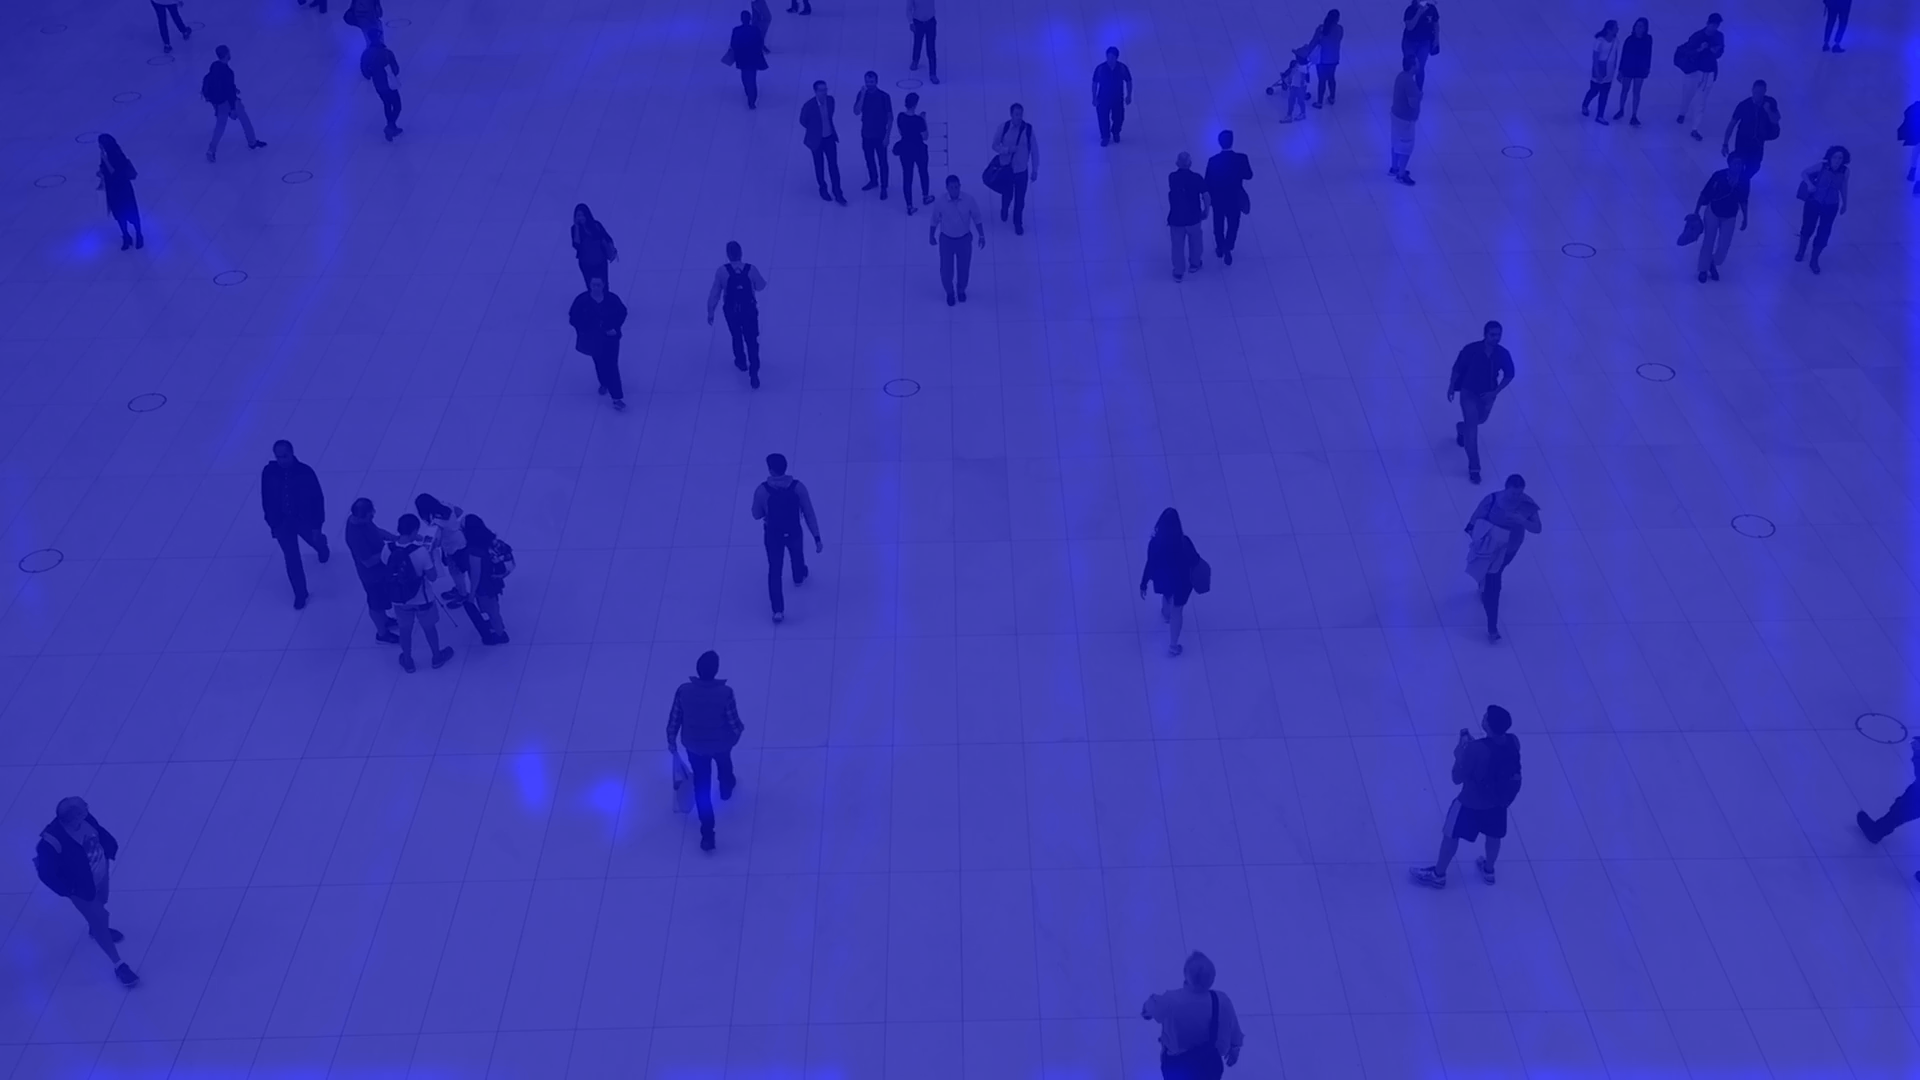

In [43]:
import numpy as np
import cv2
from IPython.display import display, Image

print("Creating heatmap...")

# Normalizing heatmap
heatmap_norm = heatmap_acc / (heatmap_acc.max() + 1e-6)

# Applying strong contrast boost — makes low-density areas visible
heatmap_norm = np.power(heatmap_norm, 0.35)  # gamma < 1 brightens faint regions

# Resizing to original video size
heatmap_vis = cv2.resize(heatmap_norm, (width, height))

# Convert to 8-bit for OpenCV colormap
heatmap_vis = np.clip(heatmap_vis * 255 * 2.5, 0, 255).astype(np.uint8)

# Slight blur to smooth the transitions
heatmap_vis = cv2.GaussianBlur(heatmap_vis, (0, 0), sigmaX=10, sigmaY=10)

# Convert to colorful heatmap
heatmap_color = cv2.applyColorMap(heatmap_vis, cv2.COLORMAP_JET)

# Read first frame for overlay background
cap = cv2.VideoCapture(INPUT_VIDEO)
ret, bg = cap.read()
cap.release()
if not ret:
    bg = np.zeros((height, width, 3), dtype=np.uint8)

# Overlay — stronger heatmap for better visibility
overlay = cv2.addWeighted(bg, 0.3, heatmap_color, 0.9, 0)

# Saving result
cv2.imwrite(HEATMAP_PATH, overlay)
print("✅ Saved improved heatmap overlay to", HEATMAP_PATH)

from IPython.display import display, Image
display(Image(HEATMAP_PATH))

In [44]:
print("Heatmap debug:")
print("Shape:", heatmap_acc.shape)
print("Min:", np.min(heatmap_acc))
print("Max:", np.max(heatmap_acc))
print("Mean:", np.mean(heatmap_acc))
print("Sum:", np.sum(heatmap_acc))

Heatmap debug:
Shape: (540, 960)
Min: 0.0
Max: 456.0
Mean: 0.025511188
Sum: 13225.0


In [45]:
print("Heatmap stats:",
      "min:", np.min(heatmap_acc),
      "max:", np.max(heatmap_acc),
      "sum:", np.sum(heatmap_acc))

Heatmap stats: min: 0.0 max: 456.0 sum: 13225.0


# READ ME

This project detects people in a video, tracks their movements, counts them as they cross designated lines (IN/OUT), and generates a heatmap showing areas with the most movement.

**Detection Method**

Object Detection: YOLOv8 (yolov8n.pt) is used to detect objects in each video frame.

Class Filter: Only the person class (COCO class 0) is tracked.

Tracking: DeepSort from deep_sort_realtime tracks individual people across frames using their bounding boxes.

Bounding Boxes: Each detected person gets a bounding box and a unique track_id.

**Line Coordinates**

Two horizontal lines are used to determine IN/OUT counting:

Upper Line (y_upper): Default at ~35% of frame height

People moving downward across this line are counted as IN

Lower Line (y_lower): Default at ~65% of frame height

People moving upward across this line are counted as OUT

The exact coordinates are automatically computed based on video frame height if not manually set.

y_upper = int(height * 0.35)  # green line
y_lower = int(height * 0.65)  # red line

**IN/OUT Counting Logic**

Track History: For each person (track_id), store the last few center points of their bounding box (deque with max length 8).

Movement Direction:

Compute dx, dy as the difference between the first and last center in the history.

dy > 0 → moving downward, dy < 0 → moving upward.

IN Counting:

If the person was above y_upper and now is below y_upper and moving downward (dy > 0) → IN.

OUT Counting:

If the person was below y_lower and now is above y_lower and moving upward (dy < 0) → OUT.

Avoid Double Counting: Each track_id is counted only once per direction.

***Heatmap Generation***

Each person's center coordinates are scaled down and accumulated in a heatmap array.

The heatmap is normalized, blurred, color-mapped (JET), and overlaid on a frame for visualization.

Shows areas with the highest density of people movement.

Visual Output

Video: Annotated with bounding boxes, track IDs, lines, and IN/OUT counts.

Heatmap: Saved as outputs/people_heatmap.png.